In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import  models, optimizers, layers, activations
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2, ResNet50, Xception

import wandb
from wandb.keras import WandbCallback

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
default_parameters = dict(
    data_aug = True,
    pre_trained_model = 'InceptionResNetV2',
    batch_size = 64,
    final_dense = 256,
    final_dropout = 0.5,
    k_freeze_percent = 0.7, 
    batch_norm = True,
    activation = "leaky_relu"
    )

In [6]:
run = wandb.init(config=default_parameters, project="cs6910_assignment_2", entity="arnesh_neil")
config = wandb.config

wandb: Currently logged in as: neilghosh (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
image_size = (128,128)
input_size = (128,128,3)
batch_size = config.batch_size

class_names = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi',
               'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']

data_aug = config.data_aug

if data_aug:
    train_gen = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, height_shift_range=0.2,
                                 shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='reflect',
                                   rescale=1./255, validation_split=0.1)
else:
    train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [9]:
train_ds = train_gen.flow_from_directory(
    directory='C:/Users/neilg/PycharmProjects/DL/A2/partA/nature_12K/inaturalist_12K/train/',
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset="training")

val_ds = train_gen.flow_from_directory(
    directory='C:/Users/neilg/PycharmProjects/DL/A2/partA/nature_12K/inaturalist_12K/train/',
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset="validation")

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


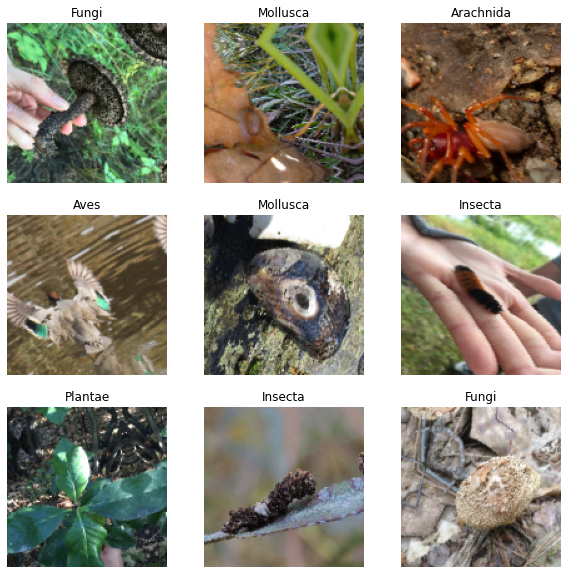

In [10]:
plt.figure(figsize=(10, 10))
images, labels = val_ds.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.where(labels[i] == 1)[0][0]])
    plt.axis("off")
    
plt.show()

In [16]:
def use_pretrained_model(pre_trained_model, batch_size, final_dense, final_dropout, k_freeze_percent, batch_norm, activation):
    if pre_trained_model == 'InceptionV3':
        model = InceptionV3(input_shape = input_size, include_top = False, weights = 'imagenet') # leaving out the last layer since we have only 10 classes
        k = math.ceil(k_freeze_percent*311)
    elif pre_trained_model == 'InceptionResNetV2':
        model = InceptionResNetV2(input_shape = input_size, include_top = False, weights = 'imagenet')
        k = math.ceil(k_freeze_percent*780)
    elif pre_trained_model == 'ResNet50':
        model = ResNet50(input_shape = input_size, include_top = False, weights = 'imagenet')
        k = math.ceil(k_freeze_percent*175)
    elif pre_trained_model == 'Xception':
        model = Xception(input_shape = input_size, include_top = False, weights = 'imagenet')
        k = math.ceil(k_freeze_percent*132)
        
    
    i = 0
    for layer in model.layers:
        layer.trainable = False
        i+=1
        if(i==k):
            break
        
    x = layers.Flatten()(model.output) # flattening the last layer to a single layer
    
    if activation == "relu":
        x = layers.Dense(final_dense, layers.ReLU())(x)
    elif activation == "leaky_relu":
        x = layers.Dense(final_dense, layers.LeakyReLU(alpha=0.1))(x)

    if batch_norm:
        x = layers.BatchNormalization()(x)

    x = layers.Dropout(final_dropout)(x) # adding a dropout
    x = layers.Dense(10, tf.nn.softmax)(x) # final softmax function
    
    final_model = Model(model.input,x)
    final_model.summary()
    
    return final_model

In [17]:
pre_trained_model = config.pre_trained_model
batch_size = config.batch_size
final_dense = config.final_dense
final_dropout = config.final_dropout
k_freeze_percent = config.k_freeze_percent
batch_norm = config.batch_norm
activation = config.activation

In [18]:
model = use_pretrained_model(pre_trained_model, batch_size, final_dense, final_dropout, k_freeze_percent, batch_norm, activation)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=[WandbCallback()])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_406 (BatchN (None, 63, 63, 32)   96          conv2d_406[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, 63, 63, 32)   0           batch_normalization_406[0][0]    
_______________________________________________________________________________________

conv2d_464 (Conv2D)             (None, 13, 13, 48)   13824       activation_463[0][0]             
__________________________________________________________________________________________________
batch_normalization_461 (BatchN (None, 13, 13, 32)   96          conv2d_461[0][0]                 
__________________________________________________________________________________________________
batch_normalization_464 (BatchN (None, 13, 13, 48)   144         conv2d_464[0][0]                 
__________________________________________________________________________________________________
activation_461 (Activation)     (None, 13, 13, 32)   0           batch_normalization_461[0][0]    
__________________________________________________________________________________________________
activation_464 (Activation)     (None, 13, 13, 48)   0           batch_normalization_464[0][0]    
__________________________________________________________________________________________________
conv2d_460

__________________________________________________________________________________________________
batch_normalization_511 (BatchN (None, 6, 6, 128)    384         conv2d_511[0][0]                 
__________________________________________________________________________________________________
activation_511 (Activation)     (None, 6, 6, 128)    0           batch_normalization_511[0][0]    
__________________________________________________________________________________________________
conv2d_512 (Conv2D)             (None, 6, 6, 160)    143360      activation_511[0][0]             
__________________________________________________________________________________________________
batch_normalization_512 (BatchN (None, 6, 6, 160)    480         conv2d_512[0][0]                 
__________________________________________________________________________________________________
activation_512 (Activation)     (None, 6, 6, 160)    0           batch_normalization_512[0][0]    
__________

__________________________________________________________________________________________________
block17_20_ac (Activation)      (None, 6, 6, 1088)   0           block17_20[0][0]                 
__________________________________________________________________________________________________
conv2d_566 (Conv2D)             (None, 6, 6, 256)    278528      block17_20_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_566 (BatchN (None, 6, 6, 256)    768         conv2d_566[0][0]                 
__________________________________________________________________________________________________
activation_566 (Activation)     (None, 6, 6, 256)    0           batch_normalization_566[0][0]    
__________________________________________________________________________________________________
conv2d_562 (Conv2D)             (None, 6, 6, 256)    278528      block17_20_ac[0][0]              
__________

Epoch 1/15
141/141 [==============================] - 121s 860ms/step - loss: 1.9135 - accuracy: 0.4200 - val_loss: 99.5375 - val_accuracy: 0.4434
Epoch 2/15
141/141 [==============================] - 98s 695ms/step - loss: 1.4228 - accuracy: 0.5361 - val_loss: 1.3940 - val_accuracy: 0.5305
Epoch 3/15
141/141 [==============================] - 97s 689ms/step - loss: 1.3687 - accuracy: 0.5772 - val_loss: 1.3866 - val_accuracy: 0.5886
Epoch 4/15
141/141 [==============================] - 104s 738ms/step - loss: 1.2415 - accuracy: 0.6114 - val_loss: 2.3214 - val_accuracy: 0.5796
Epoch 5/15
141/141 [==============================] - 106s 751ms/step - loss: 1.1320 - accuracy: 0.6363 - val_loss: 1.1659 - val_accuracy: 0.6176
Epoch 6/15
141/141 [==============================] - 130s 925ms/step - loss: 1.0841 - accuracy: 0.6549 - val_loss: 1.2088 - val_accuracy: 0.5836
Epoch 7/15
141/141 [==============================] - 156s 1s/step - loss: 1.0221 - accuracy: 0.6679 - val_loss: 6.1208 - val

In [19]:
model.save('best_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_model\assets


In [ ]:
model = tf.keras.models.load_model('best_model')

In [21]:
test_gen = ImageDataGenerator(rescale=1./255)

test_ds = test_gen.flow_from_directory(
    directory='C:/Users/neilg/PycharmProjects/DL/A2/partA/nature_12K/inaturalist_12K/val/',
    target_size=image_size,
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=True,
    seed=71)

Found 2000 images belonging to 10 classes.


In [22]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

2000/2000 - 47s - loss: 1.1064 - accuracy: 0.6355


In [23]:
wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})